In [1]:
import underworld as uw
import underworld.function as fn
from underworld import UWGeodynamics as GEO
import numpy as np
import math

import os
import h5py   
import matplotlib.pyplot as plt

loaded rc file /opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

# solver parameters
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-2
GEO.rcParams['initial.nonlinear.max.iterations'] = 50
GEO.rcParams["nonlinear.tolerance"] = 1e-2
GEO.rcParams['nonlinear.max.iterations'] = 50
GEO.rcParams["popcontrol.particles.per.cell.2D"] = 30
GEO.rcParams["swarm.particles.per.cell.2D"] = 30
GEO.rcParams["surface.pressure.normalization"] = True
GEO.rcParams["pressure.smoothing"] = True

In [3]:
# input parameters
fdir_output = "LithoPressureCalculation_StickyAir"

xmax_box = 400             # unit [km]
ymin_box,ymax_box = -400,0 # unit [km]

x_box = xmax_box
y_box = -ymin_box+ymax_box

if uw.mpi.rank == 0:
    x_res,y_res = 40,40 
    npoints = 100  

else:    
    x_res,y_res = 512,512
    npoints = 1200

    
conv_vel = 1.0 * u.centimeter / u.year

checkpoint_interval = 0.1 * u.megayears
dt = 2.5 * u.kiloyear
Total_Convergence  = 500 *u.kilometer
Total_Time = (Total_Convergence / conv_vel).to(u.megayear)


# scaling
ref_velocity = 1. * u.centimeter / u.year
ref_density = 1000. * u.kilogram / u.meter**3
ref_length = 100. * u.kilometer  
ref_gravity =  10.0 * u.meter / u.second**2
gravity = 10.0 * u.meter / u.second**2
#ref_vicosity = 1e21 * u.pascal * u.second

T0 = 273.15 * u.degK  # 0 * u.degC
Tz = 1573.15 * u.degK # 1300 * u.degC at litho bottom
# Tz = 1300 + 273.15 + (-ymin_box-ml_thickness)*120

bodyforce = ref_density * ref_gravity
KL = ref_length
Kt = KL / ref_velocity
KM = bodyforce * KL**2 * Kt**2
KT = (Tz - T0)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT


dx = GEO.nd(x_box/x_res*u.kilometer)
dy = GEO.nd(y_box/y_res*u.kilometer)
    
    
Model = GEO.Model(elementRes=(x_res, y_res),
                  minCoord=(0. * u.kilometer, ymin_box*u.kilometer),
                  maxCoord=(xmax_box*u.kilometer, ymax_box*u.kilometer),
                  gravity=(0.0, -gravity))
Model.outputDir=fdir_output
Model.minStrainRate = 1e-18 / u.second



if uw.mpi.rank == 0:
    print('Length, km = ', GEO.dimensionalise(1., u.kilometer))
    print('Time, Myr = ',GEO.dimensionalise(1., u.megayear))
    print('Pressure, MPa = ',GEO.dimensionalise(1., u.megapascal))
    print('Temperature, K = ',GEO.dimensionalise(1., u.degK))
    print('Velocity, cm/yr = ',GEO.dimensionalise(1., u.centimeter / u.year))
    print('Viscosity, Pa S = ',GEO.dimensionalise(1.,u.pascal * u.second))
    


	Global element size: 40x40
	Local offset of rank 0: 0x0
	Local range of rank 0: 40x40
In func WeightsCalculator_CalculateAll(): for swarm "7SJG38Y1__swarm"
	done 33% (534 cells)...
	done 67% (1067 cells)...
	done 100% (1600 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "7SJG38Y1__swarm"
Length, km =  100.0 kilometer
Time, Myr =  10.0 megayear
Pressure, MPa =  1000.0 megapascal
Temperature, K =  1300.0 kelvin
Velocity, cm/yr =  1.0 centimeter / year
Viscosity, Pa S =  3.15576e+23 pascal * second


In [4]:
H0 = 0.*u.kilometer
H1 = 50.*u.kilometer
Z_m2 = -200.*u.kilometer

wavelength = 200*u.kilometer

m1_Shape = fn.input()[1] > GEO.nd(H1)*fn.math.cos(2.*np.pi*fn.input()[0] / GEO.nd(wavelength))+GEO.nd(Z_m2) 
m2_Shape = fn.input()[1] <= GEO.nd(H1)*fn.math.cos(2.*np.pi*fn.input()[0] / GEO.nd(wavelength))+GEO.nd(Z_m2) 

m1 = Model.add_material(name="material 1", shape=m1_Shape)
m2 = Model.add_material(name="material 2", shape=m2_Shape) 



coords = np.ndarray((npoints, 2))
x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
y = np.ones_like(x)
coords[:, 0] = x
coords[:, 1] = GEO.nd(H1)*np.cos(2.*np.pi*x / GEO.nd(wavelength))+GEO.nd(Z_m2) 
Model.add_passive_tracers(name="Interface", vertices=coords)

# coords = np.ndarray((npoints, 2))
# x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
# y = np.ones_like(x)*GEO.nd(Z_lc)
# coords[:, 0] = x
# coords[:, 1] = y
# Model.add_passive_tracers(name="Moho", vertices=coords)

# coords = np.ndarray((npoints, 2))
# x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)
# y = np.ones_like(x)*GEO.nd(Z_ml)
# coords[:, 0] = x
# coords[:, 1] = y
# Model.add_passive_tracers(name="LAB", vertices=coords)


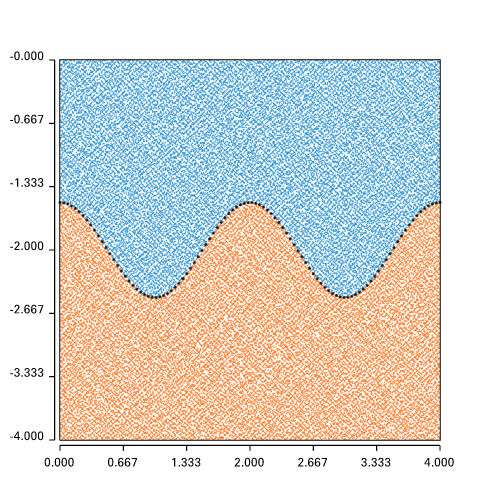

In [5]:
if uw.mpi.rank == 0:
    from underworld import visualisation as vis
    fig_res = (500,500)

    Fig = vis.Figure(resolution=fig_res,rulers=True,margin = 60,rulerticks=7,quality=3,clipmap=False)
    Fig.Points(Model.Interface_tracers, pointSize=4.0)
#     Fig.Points(Model.Moho_tracers, pointSize=4.0)
#     Fig.Points(Model.LAB_tracers, pointSize=4.0)
    Fig.Points(Model.swarm, Model.materialField,fn_size=2.0,discrete=True,colourBar=False)
    Fig.show()
    Fig.save("LithoPressureCalculation_SimpleCase_Modelsetup.png")

In [6]:
m1.density = 1000. * u.kilogram / u.metre**3
m2.density = 2000. * u.kilogram / u.metre**3 

m1_rho = 1000. * u.kilogram / u.metre**3
m2_rho = 2000. * u.kilogram / u.metre**3 

Model.init_model(pressure='lithostatic')

/opt/venv/lib/python3.10/site-packages/underworld/UWGeodynamics/_model.py:1584: UserWarning: Skipping the steady state calculation: No diffusivity variable defined on Model
  warnings.warn("Skipping the steady state calculation: No diffusivity variable defined on Model")


HNVV3XMW__cm


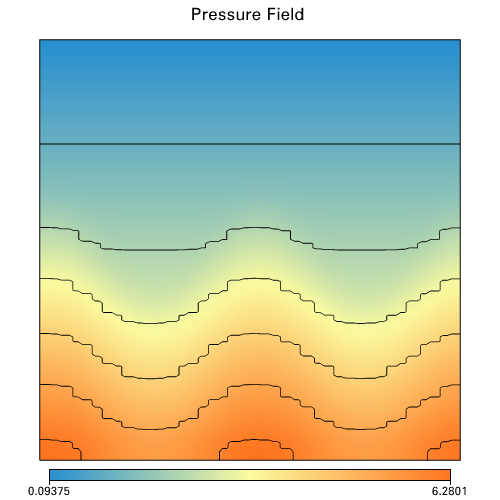

HNVV3XMW__cm

In [7]:
if uw.mpi.rank == 0:
    Fig = vis.Figure(figsize= fig_res, title="Pressure Field", quality=3)
    Fig.Surface(Model.mesh, Model.pressureField)
    Fig.Contours(Model.mesh, Model.pressureField, interval= 1, limits=( 0,6.),colours='Black', colourBar=False)
    Fig.show()
    Fig.save_image("pressure_lithofn.png")

In [8]:
# if uw.mpi.rank == 0:
#     Fig = vis.Figure(figsize= fig_res, title="Pressure Field", quality=3)
#     Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
#     Fig.Contours(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal), interval= 500, limits=( 0,4000.),colours='Black', colourBar=False)
#     Fig.show()

In [9]:
npoints = x_res+1
distancex = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints)

npoints = y_res+1
distancey = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), npoints)

In [10]:
# rho_left = Model._densityFn.evaluate(Model.left_wall)
# rho_left[rho_left<1.5e-25].shape,rho_left.shape

# Fig, ax1,  = plt.subplots(1,1,figsize=(10,4))

# ax1.set_title("Pressure at sides")
# ax1.set_xlabel('Distance X [km]')
# ax1.set_ylabel('Pressure [megapascal]')


# ax1.scatter(rho_left/GEO.nd(1*u.kilogram / u.metre**3),distancey/GEO.nd(1*u.kilometer))
# #ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_analytic/GEO.nd(1*u.megapascal) ,'o', color = 'black',label="analytic")

# ax1.legend(loc='lower right')
# #plt.savefig(Model.outputDir+"/Vel-{0}.png".format(Model.checkpointID))
# #plt.show()

In [11]:
# x_mid = GEO.nd(xmax_box*u.kilometer)/2.
# axis  = np.where((Model.mesh.data[:,0]<=x_mid+dx/4)&(Model.mesh.data[:,0]>=x_mid-dx/4))
# IndexSets = Model.mesh.specialSets["Empty"]
# for index in axis:
#     IndexSets.add(index)

# tmp = uw.utils.Integral(fn=Model._densityFn*GEO.nd(gravity),mesh=Model.mesh, integrationType='Surface',surfaceIndexSet=IndexSets)
# pbot_denFn_mid = tmp.evaluate()[0]
# pbot_denFn_mid

### Darcy Flow solver

- [underworld3/Examples-PoissonEquation](https://github.com/underworldcode/underworld3/tree/76c47b4df64731a10a1c4390908982d3f7fc4c6d/Jupyterbook/Notebooks/Examples-PoissonEquation)
- [underworld2/examples/09_Groundwater_Flow](http://172.17.0.1:8888/notebooks/Underworld/examples/09_Groundwater_Flow.ipynb)
- https://github.com/underworldcode/underworld2/issues/214 (uw.systems.sle.VectorAssemblyTerm_NA_i__Fn_i)
- [model_library/examples/1_17_Groundwater_Flow_Temperature_Advection](https://github.com/underworldcode/model_library/blob/98ad9e29c5eafcc54c568e987ae012c0fda09ac9/examples/1_17_Groundwater_Flow_Temperature_Advection.ipynb#L327)

solver pressure Poisson problem (Jourdon & May, 2022):
$\nabla \cdot \nabla P =  \nabla \cdot (\rho g )$ with boundary condition: $P = 0 \: (x \in \partial \Omega_{surf})$
    
##### Reference
- Jourdon, A., & May, D. A. (2022). An efficient parallel method to compute lithostatic pressure in thermo-mechanical geodynamic models. Solid Earth Discussions, 2022, 1-20.


In [12]:
###----------------------------

from copy import copy

minCoord = tuple([GEO.nd(val) for val in Model.minCoord])
maxCoord = tuple([GEO.nd(val) for val in Model.maxCoord])

elementType = "Q1"
mesh = uw.mesh.FeMesh_Cartesian(elementType=elementType,
                             elementRes=Model.elementRes,
                             minCoord=minCoord,
                             maxCoord=maxCoord,
                             periodic=Model.periodic)

gwPressureField           = mesh.add_variable( nodeDofCount=1 )
lithoPressureField        = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField = mesh.add_variable( nodeDofCount=1 )
velocityField             = mesh.add_variable( nodeDofCount=2 )
velocityField.data[:]= 0.

#gwPressureField.data[:] = Model.lithostatic_pressureField.evaluate(mesh)

# maxgwpressure = 0.5
# yCoordFn  = uw.function.input()[1]
# initialFn = -1. * yCoordFn * maxgwpressure
# gwPressureField.data[:] = initialFn.evaluate(mesh)


# Boundary conditions
topWall    = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]


BCsType = 2

if BCsType == 1:
#--- Case 1 $P = 0 \: (x \in \partial \Omega_{surf})$ NeumannCondition
    flux = uw.function.Function.convert(0.)
    cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=gwPressureField,indexSetsPerDof=topWall)
    
#     flux = mesh.add_variable( nodeDofCount=2 )
#     flux.data[:]=0.
#     cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=velocityField,indexSetsPerDof=[topWall,topWall])
    cond_neumann.indexSet = cond_neumann.indexSetsPerDof
    BCs = [cond_neumann]
    print("type 1")

elif BCsType == 2:
#--- Case 2 $P = 0 \: (x \in \partial \Omega_{surf})$ DirichletCondition 
    gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
                                               indexSetsPerDof = ( topWall) )
    # gwPressureBC = uw.conditions.DirichletCondition( variable        = gwPressureField, 
    #                                                indexSetsPerDof = ( topWall+ bottomWall ))
    BCs = [gwPressureBC]

elif BCsType == 3:
#--- Case 3 $P = 0 \: (x \in \partial \Omega_{surf})$ NeumannCondition + v = 0 DirichletCondition
    AllIndexSets = mesh.specialSets["Empty"]
    for index in mesh.data_nodegId:
        AllIndexSets.add(int(index))
    cond_dirichlet =uw.conditions.DirichletCondition( variable        = velocityField, 
                                                     indexSetsPerDof = (AllIndexSets,AllIndexSets)) 
    flux = uw.function.Function.convert(0.)
    cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=gwPressureField,indexSetsPerDof=topWall)
    #cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=velocityField,indexSetsPerDof=topWall)
    cond_neumann.indexSet = cond_neumann.indexSetsPerDof
    BCs = [cond_neumann,cond_dirichlet]
else:
    print("No type of BCs settings")

# swarm = copy(Model.swarm)
# materialIndex = copy(Model.materialField)
# materialVelocity = copy(Model.velocityField)

swarm = uw.swarm.Swarm(mesh=mesh)
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=1)
swarm.populate_using_layout(swarmLayout)

materialIndex = swarm.add_variable( dataType="int",count=1 )
H0 = 0.*u.kilometer
H1 = 50.*u.kilometer
Z_m2 = -200.*u.kilometer
wavelength = 200*u.kilometer

m1_Shape = fn.input()[1] > GEO.nd(H1)*fn.math.cos(2.*np.pi*fn.input()[0] / GEO.nd(wavelength))+GEO.nd(Z_m2) 
m2_Shape = fn.input()[1] <= GEO.nd(H1)*fn.math.cos(2.*np.pi*fn.input()[0] / GEO.nd(wavelength))+GEO.nd(Z_m2) 
m1_index = 1
m2_index = 2
conditions = [ (m1_Shape, m1_index),
               ( True , m2_index) ]
materialfn = uw.function.branching.conditional( conditions )
materialIndex.data[:]  = materialfn.evaluate(swarm)

materialVelocity  = swarm.add_variable( dataType="double", count=2 )
materialVelocity.data[:]= 0.

Ka = 1.
hydraulicDiffusivityMap = { m1_index: Ka, m2_index : Ka}
hydraulicDiffusivityMapFn = uw.function.branching.map( fn_key = materialIndex, mapping = hydraulicDiffusivityMap )

g = uw.function.misc.constant((0.0, -GEO.nd(gravity)))
densityFn = uw.function.branching.map( fn_key=materialIndex, 
                                    mapping={ m1_index: GEO.nd(m1_rho), m2_index: GEO.nd(m2_rho) } )

forceFn = densityFn * (0.0,-GEO.nd(gravity))
fn_bodyforce = forceFn 

gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
                                            pressureField=gwPressureField, 
                                            fn_diffusivity = hydraulicDiffusivityMapFn,
                                            conditions=BCs,
                                            fn_bodyforce=fn_bodyforce , 
                                            voronoi_swarm=swarm,
                                            swarmVarVelocity=materialVelocity)
gwsolver = uw.systems.Solver(gwadvDiff)
gwsolver.solve()

	Global element size: 40x40
	Local offset of rank 0: 0x0
	Local range of rank 0: 40x40
In func WeightsCalculator_CalculateAll(): for swarm "U0KN2EI2__swarm"
	done 33% (534 cells)...
	done 67% (1067 cells)...
	done 100% (1600 cells)...
WeightsCalculator_CalculateAll(): finished update of weights for swarm "U0KN2EI2__swarm"
Linear solver (SB7GW9KR__system-execute) 
Linear solver (SB7GW9KR__system-execute), solution time 6.293432e-03 (secs)


In [13]:
# Fig = vis.Figure(figsize= fig_res, title="Density Field", quality=3)
# Fig.Surface(mesh, densityFn)
# #Fig.Contours(Model.mesh, Model.pressureField, interval= 1, limits=( 0,6.),colours='Black', colourBar=False)
# Fig.show()
# #Fig.save_image("pressure_lithofn.png")


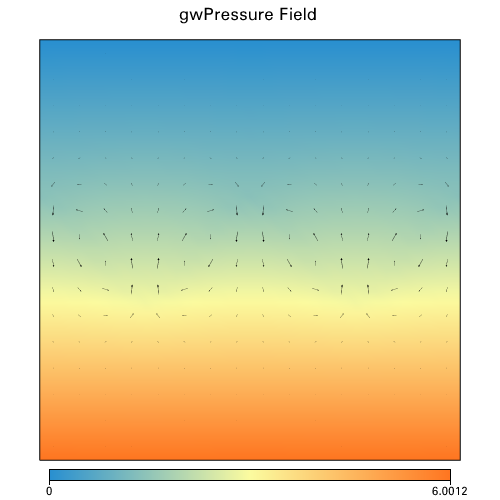

'pressure_darcy.png'

In [14]:
#if uw.mpi.rank == 0:
Fig = vis.Figure(figsize= fig_res, title="gwPressure Field", quality=3)
Fig.Surface(mesh,gwPressureField)
#Fig.Contours(mesh, gwPressureField,interval= 1, limits=( 0,6),colours='Black', colourBar=False)
#Fig.Surface(mesh, GEO.dimensionalise(press, u.megapascal))
Fig.VectorArrows(mesh, velocityField) 
#Fig.Contours(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal), interval= 500, limits=( 0,4000.),colours='Black', colourBar=False)
Fig.show()
Fig.save_image("pressure_darcy.png")

[ 6.00118394] [ 5.99893508] (41, 1)


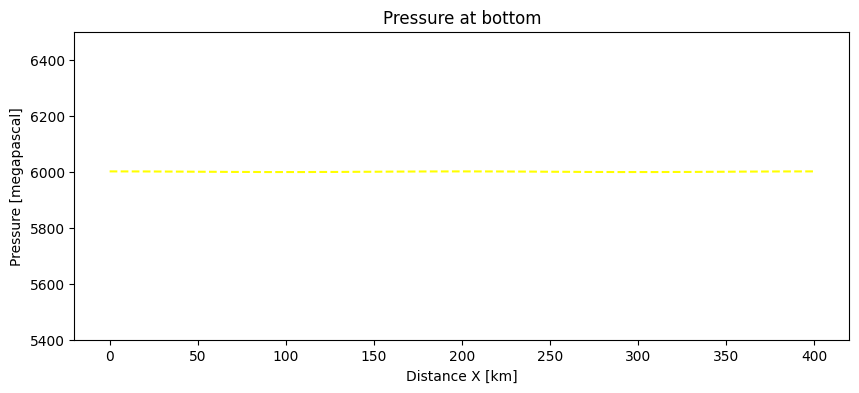

In [15]:
leftWall = mesh.specialSets["MinI_VertexSet"]

pbot_solver = gwPressureField.evaluate(bottomWall)-gwPressureField.evaluate(topWall)
pbot_solver_left = gwPressureField.evaluate(leftWall)
print(pbot_solver[0],pbot_solver[10],pbot_solver.shape)

Fig, ax1,  = plt.subplots(1,1,figsize=(10,4))
ax1.set_title("Pressure at bottom")
ax1.set_xlabel('Distance X [km]')
ax1.set_ylabel('Pressure [megapascal]')
ax1.set_ylim ([5400,6500])
ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_solver/GEO.nd(1*u.megapascal) ,'--', color = 'yellow',label="solver")
#ax1.legend(loc='lower right')

### Stokes solver

In [16]:
# ###----------------------------

# from copy import copy

# # minCoord = tuple([GEO.nd(val) for val in Model.minCoord])
# # maxCoord = tuple([GEO.nd(val) for val in Model.maxCoord])

# # mesh = uw.mesh.FeMesh_Cartesian(elementType=Model.elementType,
# #                              elementRes=Model.elementRes,
# #                              minCoord=minCoord,
# #                              maxCoord=maxCoord,
# #                              periodic=Model.periodic)

# # swarm = uw.swarm.Swarm(mesh=mesh )
# #materialVariable   = swarm.add_variable( dataType="int", count=1 )

# mesh = copy(Model.mesh)
# swarm = copy(Model.swarm)
# material = copy(Model.materialField)

# vel   = uw.mesh.MeshVariable(mesh,Model.mesh.dim)
# press = uw.mesh.MeshVariable(mesh.subMesh, 1)
# press_solver = uw.mesh.MeshVariable(mesh.subMesh, 1)
# vel.data[:]   = [0.,0.]    #(0.,)*Model.mesh.dim
# press.data[:] = 0.
# press_solver.data[:] = 0.
# fn_viscosity = 1.    #fn_viscosity = GEO.nd(1e24 * u.pascal * u.second)
# fn_bodyforce = Model._buoyancyFn
# fn_source = Model._buoyancyFn

# strainRate = fn.tensor.symmetric(vel.fn_gradient)
# # strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)
# # strainRate_2ndInvariant.evaluate(mesh)
# stressFn = 2. * fn_viscosity * strainRate
# stress = fn.tensor.second_invariant(stressFn)

# press_solver = press-stress

# advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=vel, order=mesh.dim )

# allWalls = mesh.specialSets['AllWalls_VertexSet']

# AllIndexSets = mesh.specialSets["Empty"]
# for index in mesh.data_nodegId:
#     AllIndexSets.add(int(index))
    
# #dir =uw.conditions.DirichletCondition( variable  = vel, 
# #indexSetsPerDof = (allWalls , allWalls ) ) 

# flux = uw.mesh.MeshVariable(mesh=mesh,nodeDofCount=mesh.dim)
# flux.data[:] = (0.,)*Model.mesh.dim

# top = mesh.specialSets['Top_VertexSet']
# #flux = uw.function.Function.convert((0.,)*Model.mesh.dim)
# cond_neumann = uw.conditions.NeumannCondition(fn_flux=flux,variable=vel,indexSetsPerDof=(None,top))

# iWalls = mesh.specialSets["Left_VertexSet"]+mesh.specialSets["Right_VertexSet"]
# jWalls = mesh.specialSets['Bottom_VertexSet'] #+mesh.specialSets["Top_VertexSet"]

# #topWalls = 

# cond_dirichlet =uw.conditions.DirichletCondition( variable        = vel, 
#                                                indexSetsPerDof = ( iWalls, jWalls) ) 


# # cond_dirichlet =uw.conditions.DirichletCondition( variable        = vel, 
# #                                                indexSetsPerDof = ( iWalls, jWalls) ) 

# #cond_dirichlet =uw.conditions.DirichletCondition( variable        = vel, 
# #                                                indexSetsPerDof = ( allWalls, allWalls) ) 

# # cond_dirichlet =uw.conditions.DirichletCondition( variable        = vel, 
# #                                                  indexSetsPerDof = (AllIndexSets,AllIndexSets)) 

# conditions = list()
# conditions.append(cond_neumann )
# conditions.append(cond_dirichlet)
# stokes = uw.systems.Stokes(velocityField=vel,
#                 pressureField=press,
#                 conditions=conditions,
#                 voronoi_swarm=swarm,
#                 fn_viscosity=fn_viscosity,
#                 fn_bodyforce=fn_bodyforce)

# # stokes = uw.systems.SteadyStateHeat(
# #     temperatureField=press,
# #     fn_diffusivity=vel,
# #     fn_heating=fn_bodyforce,
# #     voronoi_swarm=swarm,
# #     conditions=conditions)

# solver = uw.systems.Solver(stokes)
# solver.solve()

# dt = advector.get_max_dt()  
# advector.integrate(dt)

In [ ]:
# if uw.mpi.rank == 0:
#     Fig = vis.Figure(figsize= fig_res, title="Pressure Field", quality=3)
#     Fig.Surface(mesh,press)
#     Fig.Contours(mesh, press,interval= 1, limits=( 0,6),colours='Black', colourBar=False)
#     #Fig.Surface(mesh, GEO.dimensionalise(press, u.megapascal))
#     Fig.VectorArrows(mesh, vel) 
#     #Fig.Contours(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal), interval= 500, limits=( 0,4000.),colours='Black', colourBar=False)
#     Fig.show()
#     Fig.save_image("pressure_stokes.png")

### Spectral tool (From Dan)

Underworld2 currently supports area (volume) and surface integrals. But there is no inherent capacity to integrate a 2D function independently along separate axes. However, we can generate a Fourier representation of such an integral. We'll consider a 2D scalar field $F(x,y)$, over a domain with height $L$, width $W$. We want to determine the function representing the the integrated value over the y-axis: 


\begin{equation}f(x) = \int_0^L F(x,y) \mathop{dy}   \end{equation}

We can write this as a sum of periodic functions:


\begin{equation}f(x) = \frac{1}{W}  A_0  + \sum_K \frac{2}{W}  a_k \cos(kx) + \frac{2}{W}  b_k sin(kx) \end{equation} 

where:

\begin{equation} a_k = \int_0^L  \int_0^W \big( \mathop{F(x,y)} \cos(k x) \big)\mathop{dx}\mathop{dy} \end{equation} 


\begin{equation} b_k = \int_0^L  \int_0^W \big( \mathop{F(x,y)} \sin(k x) \big)\mathop{dx}\mathop{dy} \end{equation} 


\begin{equation} A_0 = \int_0^L  \int_0^W  \mathop{F(x,y)} \mathop{dx}\mathop{dy} \end{equation} 

The Underworld2 `function` and `utils` modules provides all the necessary apparatus us to compute these volume (area) integrals, and hence find the spectral coefficients  $A_0, a_k, b_k $.

In [18]:
from spectral_tools import *

In [54]:

N = 5

synthFn, coeffs = spectral_integral(Model.mesh, Model._densityFn, N=N, axisIndex=1, kernelFn=1.0, average = True, 
                      integrationType="volume",surfaceIndexSet=None, returnCoeffs=True )

In [55]:
pbot_spectral = synthFn.evaluate(Model.bottom_wall)*GEO.nd(gravity)


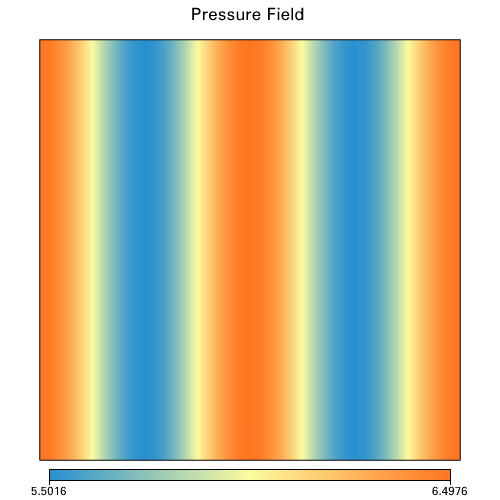

In [58]:
if uw.mpi.rank == 0:
    Fig = vis.Figure(figsize= fig_res, title="Pressure Field", quality=3)
    Fig.Surface(Model.mesh, synthFn*GEO.nd(gravity))
    #Fig.Contours(Model.mesh, Model.pressureField, interval= 1, limits=( 0,6.),colours='Black', colourBar=False)
    Fig.show()
    Fig.save_image("pressure_spectral.png")

In [46]:
###---------------------------- denFn ----------------------------###
tmp1 = uw.utils.Integral(fn=Model._densityFn*GEO.nd(gravity),mesh=Model.mesh, integrationType='volume')
tmp2 = uw.utils.Integral(fn=1.,mesh=Model.mesh, integrationType='Surface',surfaceIndexSet=Model.bottom_wall)
pbot_denFn = tmp1.evaluate()[0]/(tmp2.evaluate()[0])

tmp3 = uw.utils.Integral(fn=Model._densityFn*GEO.nd(gravity),mesh=Model.mesh, integrationType='Surface',surfaceIndexSet=Model.left_wall)
pbot_denFn_left = tmp3.evaluate()[0]
pbot_denFn_left

tmp3 = uw.utils.Integral(fn=Model._densityFn*GEO.nd(gravity),mesh=Model.mesh, integrationType='Surface',surfaceIndexSet=Model.left_wall)
pbot_denFn_right = tmp3.evaluate()[0]
pbot_denFn_left,pbot_denFn_right

###---------------------------- lithoFn ----------------------------###
pbot_lithoFn = Model.lithostatic_pressureField.evaluate(Model.bottom_wall)
pbot_lithoFn_left = Model.lithostatic_pressureField.evaluate(Model.left_wall)
pbot_lithoFn_mean = pbot_lithoFn.mean()

###---------------------------- lithoField ----------------------------###
pbot_lithoField = Model.pressureField.evaluate(Model.bottom_wall)
pbot_lithoField_left = Model.pressureField.evaluate(Model.left_wall)
pbot_lithoField_mean = pbot_lithoField.mean()

###---------------------------- analytic ----------------------------###
pbot_m1 = (-GEO.nd(H1)*np.cos(2.*np.pi*distancex / GEO.nd(wavelength))-GEO.nd(Z_m2)) * GEO.nd(m1_rho)
pbot_m2 = (GEO.nd(H1)*np.cos(2.*np.pi*distancex / GEO.nd(wavelength))+GEO.nd(Z_m2)-GEO.nd(Model.bottom)) * GEO.nd(m2_rho) 

pbot_analytic = pbot_m1 + pbot_m2
pbot_analytic *=GEO.nd(gravity)
pbot_analytic_mean = pbot_analytic.mean()

###---------------------------- solver ----------------------------###
#pbot_solver = press_solver.evaluate(Model.bottom_wall)- press_solver.evaluate(Model.top_wall)
#pbot_solver_mean = pbot_solver.mean()


print(pbot_analytic_mean,pbot_denFn,pbot_lithoFn_mean,pbot_lithoField_mean) #,pbot_solver_mean)

#print(pbot_solver_mean)
print(pbot_denFn,pbot_denFn_left,pbot_denFn_right)

6.01219512195 5.99958333333 5.91125890402 5.82328150128
5.99958333333 6.5 6.5


In [47]:
density_anlytic = np.zeros_like(distancey)

for index,y in enumerate(distancey):
    if y >= GEO.nd(Z_m2)-GEO.nd(H1)*np.cos(2.*np.pi*0. / GEO.nd(wavelength)):
        density_anlytic[index] = GEO.nd(m2_rho)
    else:
        density_anlytic[index] = GEO.nd(m1_rho)
        
dh = distancey[1]-distancey[0]
P = np.zeros_like(distancey)
for i, y in enumerate(distancey):
    if i < npoints-1:    
        P[i+1] = P[i]+density_anlytic[i]*GEO.nd(gravity)*dh   
pbot_analytic_left = P[::-1] 

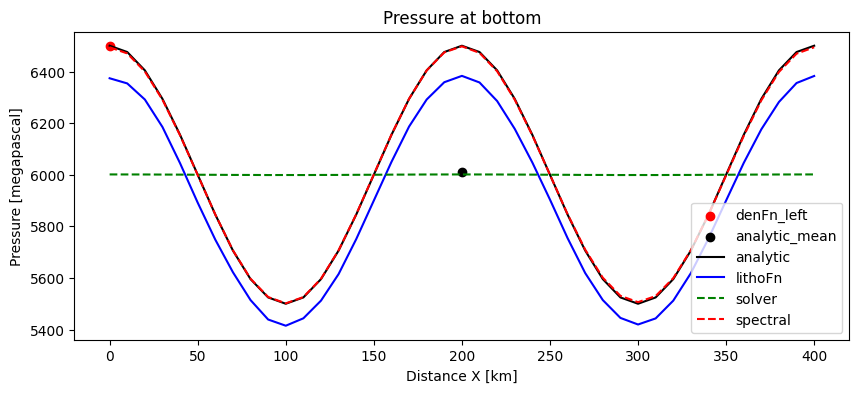

In [59]:
Fig, ax1,  = plt.subplots(1,1,figsize=(10,4))


fname = "Pressure at bottom.png"
ax1.set_title("Pressure at bottom")
ax1.set_xlabel('Distance X [km]')
ax1.set_ylabel('Pressure [megapascal]')

ax1.scatter(distancex[0]/GEO.nd(1*u.kilometer),pbot_denFn_left/GEO.nd(1*u.megapascal),c="r",label="denFn_left")
#ax1.scatter(distancex[20]/GEO.nd(1*u.kilometer),pbot_denFn/GEO.nd(1*u.megapascal),c="y",label="denFn_mean")
ax1.scatter(distancex[20]/GEO.nd(1*u.kilometer),pbot_analytic_mean/GEO.nd(1*u.megapascal),marker="o",c="black",label="analytic_mean")
ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_analytic/GEO.nd(1*u.megapascal) ,'-', color = 'black',label="analytic")
#ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_denFn/GEO.nd(1*u.megapascal) ,'-', color = 'red',label="densityFn")
ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_lithoFn/GEO.nd(1*u.megapascal) ,'-', color = 'blue',label="lithoFn")
#ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_lithoField/GEO.nd(1*u.megapascal) ,'-', color = 'green',label="lithoField")
ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_solver/GEO.nd(1*u.megapascal) ,'--', color = 'green',label="solver")
ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_spectral/GEO.nd(1*u.megapascal) ,'--', color = 'red',label="spectral")


ax1.legend(loc='lower right')
plt.savefig(fname)
#plt.show()

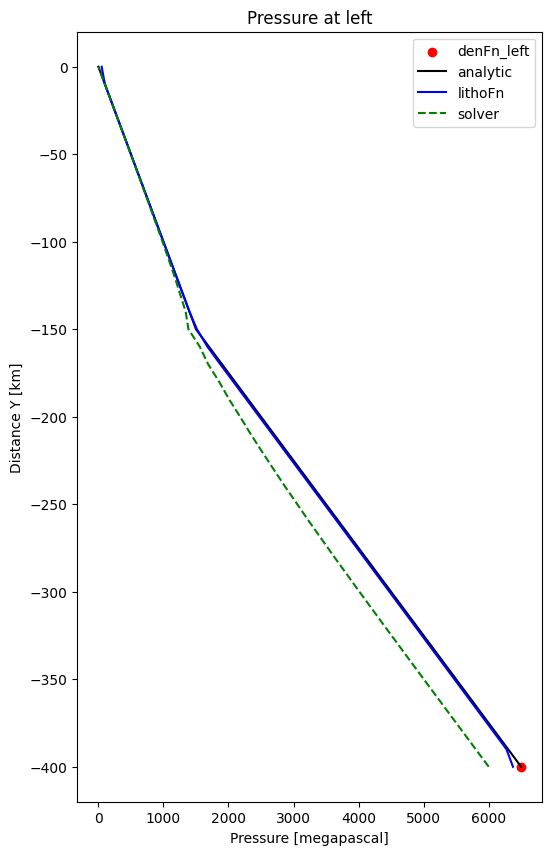

In [49]:
Fig, ax1,  = plt.subplots(1,1,figsize=(6,10))


fname = "Pressure at left.png"
ax1.set_title("Pressure at left")
ax1.set_ylabel('Distance Y [km]')
ax1.set_xlabel('Pressure [megapascal]')

ax1.scatter(pbot_denFn_left/GEO.nd(1*u.megapascal),distancey[0]/GEO.nd(1*u.kilometer),c="r",label="denFn_left")
#ax1.scatter(distancex[20]/GEO.nd(1*u.kilometer),pbot_denFn/GEO.nd(1*u.megapascal),c="y",label="denFn_mean")
#ax1.scatter(distancex[20]/GEO.nd(1*u.kilometer),pbot_analytic_mean/GEO.nd(1*u.megapascal),marker="o",c="black",label="analytic_mean")
ax1.plot(pbot_analytic_left/GEO.nd(1*u.megapascal) ,distancey/GEO.nd(1*u.kilometer),'-', color = 'black',label="analytic")
#ax1.plot(distancex/GEO.nd(1*u.kilometer),pbot_denFn/GEO.nd(1*u.megapascal) ,'-', color = 'red',label="densityFn")
ax1.plot(pbot_lithoFn_left/GEO.nd(1*u.megapascal) ,distancey/GEO.nd(1*u.kilometer),'-', color = 'blue',label="lithoFn")
ax1.plot(pbot_solver_left/GEO.nd(1*u.megapascal) ,distancey/GEO.nd(1*u.kilometer),'--', color = 'green',label="solver")

ax1.legend(loc='upper right')
plt.savefig(fname)
#plt.show()

In [ ]:
999!